# Word2Vec using Gensim on Simpsons dataset
## This notebook outlines the concepts behind analysis of Simpsons dataset

In [1]:
import re
import pandas as pd
from time import time
from collections import defaultdict

import spacy

import logging
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [2]:
df = pd.read_csv('simpsons_dataset.csv')
df.shape

(158314, 2)

In [3]:
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


### Cleaning the data
#### Checking for missing values

In [4]:
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

### Removing Missing values

In [5]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

INFO - 16:18:12: NumExpr defaulting to 4 threads.


raw_character_text    0
spoken_words          0
dtype: int64

In [6]:
#Uncomment this line if spacy core LM is not downloaded in your system
#! python -m spacy download en_core_web_sm

In [1]:
! python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [7]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [8]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

In [9]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.87 mins


In [10]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(85954, 1)

In [11]:
from gensim.models.phrases import Phrases, Phraser

In [12]:
sent = [row.split() for row in df_clean['clean']]

In [13]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 16:20:38: collecting all words and their counts
INFO - 16:20:38: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 16:20:38: PROGRESS: at sentence #10000, processed 63557 words and 52796 word types
INFO - 16:20:39: PROGRESS: at sentence #20000, processed 130938 words and 99801 word types
INFO - 16:20:39: PROGRESS: at sentence #30000, processed 192959 words and 138413 word types
INFO - 16:20:39: PROGRESS: at sentence #40000, processed 249832 words and 172509 word types
INFO - 16:20:39: PROGRESS: at sentence #50000, processed 311271 words and 208406 word types
INFO - 16:20:39: PROGRESS: at sentence #60000, processed 373576 words and 243519 word types
INFO - 16:20:39: PROGRESS: at sentence #70000, processed 436427 words and 278547 word types
INFO - 16:20:39: PROGRESS: at sentence #80000, processed 497891 words and 311704 word types
INFO - 16:20:39: collected 330480 word types from a corpus of 537095 words (unigram + bigrams) and 85954 sentences
INFO - 16:20:39: us

In [14]:
bigram = Phraser(phrases)

INFO - 16:20:41: source_vocab length 330480
INFO - 16:20:43: Phraser built with 127 phrasegrams


In [15]:
sentences = bigram[sent]

In [16]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

30242

In [17]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'like', 'know', 'get', 'hey', 'think', 'come', 'right', 'look', 'want']

### Gensim implementation of Word2Vec

In [18]:
import multiprocessing

from gensim.models import Word2Vec

- Word2Vec():
In this first step, the parameters of the model one-by-one are set up.

- build_vocab():
Here it builds the vocabulary from a sequence of sentences and thus initialized the model.
With the loggings, the progress and even more important, the effect of min_count and sample on the word corpus is monitored. These two parameters, and in particular sample, have a great influence over the performance of a model. Displaying both allows for a more accurate and an easier management of their influence.

- train():
Finally, trains the model.
The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.

In [19]:
cores = multiprocessing.cpu_count()

- min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
- window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
- size = int - Dimensionality of the feature vectors. - (50, 300)
- sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
- alpha = float - The initial learning rate - (0.01, 0.05)
- min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
- negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drawn. If set to 0, no negative sampling is used. - (5, 20)
- workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

In [20]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [21]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 16:20:58: collecting all words and their counts
INFO - 16:20:58: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 16:20:58: PROGRESS: at sentence #10000, processed 61710 words, keeping 9572 word types
INFO - 16:20:58: PROGRESS: at sentence #20000, processed 127345 words, keeping 14535 word types
INFO - 16:20:58: PROGRESS: at sentence #30000, processed 187806 words, keeping 17660 word types
INFO - 16:20:58: PROGRESS: at sentence #40000, processed 243314 words, keeping 20424 word types
INFO - 16:20:58: PROGRESS: at sentence #50000, processed 303176 words, keeping 22934 word types
INFO - 16:20:59: PROGRESS: at sentence #60000, processed 363916 words, keeping 25246 word types
INFO - 16:20:59: PROGRESS: at sentence #70000, processed 425379 words, keeping 27467 word types
INFO - 16:20:59: PROGRESS: at sentence #80000, processed 485507 words, keeping 29350 word types
INFO - 16:20:59: collected 30242 word types from a corpus of 523616 raw words and 85954 sentence

Time to build vocab: 0.04 mins


In [22]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 16:21:08: training model with 3 workers on 3309 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 16:21:09: EPOCH 1 - PROGRESS: at 63.32% examples, 121878 words/s, in_qsize 0, out_qsize 0
INFO - 16:21:09: worker thread finished; awaiting finish of 2 more threads
INFO - 16:21:09: worker thread finished; awaiting finish of 1 more threads
INFO - 16:21:09: worker thread finished; awaiting finish of 0 more threads
INFO - 16:21:09: EPOCH - 1 : training on 523616 raw words (198345 effective words) took 1.7s, 116923 effective words/s
INFO - 16:21:10: EPOCH 2 - PROGRESS: at 69.06% examples, 132603 words/s, in_qsize 0, out_qsize 0
INFO - 16:21:11: worker thread finished; awaiting finish of 2 more threads
INFO - 16:21:11: worker thread finished; awaiting finish of 1 more threads
INFO - 16:21:11: worker thread finished; awaiting finish of 0 more threads
INFO - 16:21:11: EPOCH - 2 : training on 523616 raw words (198260 effective words) took 1.4s, 140817 ef

INFO - 16:21:39: worker thread finished; awaiting finish of 2 more threads
INFO - 16:21:39: worker thread finished; awaiting finish of 1 more threads
INFO - 16:21:39: worker thread finished; awaiting finish of 0 more threads
INFO - 16:21:39: EPOCH - 19 : training on 523616 raw words (198423 effective words) took 1.7s, 119313 effective words/s
INFO - 16:21:41: EPOCH 20 - PROGRESS: at 70.97% examples, 140210 words/s, in_qsize 0, out_qsize 0
INFO - 16:21:41: worker thread finished; awaiting finish of 2 more threads
INFO - 16:21:41: worker thread finished; awaiting finish of 1 more threads
INFO - 16:21:41: worker thread finished; awaiting finish of 0 more threads
INFO - 16:21:41: EPOCH - 20 : training on 523616 raw words (198555 effective words) took 1.6s, 126827 effective words/s
INFO - 16:21:42: EPOCH 21 - PROGRESS: at 35.35% examples, 70880 words/s, in_qsize 1, out_qsize 0
INFO - 16:21:43: EPOCH 21 - PROGRESS: at 91.99% examples, 89744 words/s, in_qsize 0, out_qsize 0
INFO - 16:21:43: w

Time to train the model: 0.86 mins


In [23]:
w2v_model.init_sims(replace=True)

INFO - 16:21:59: precomputing L2-norms of word weight vectors


In [24]:
w2v_model.wv.most_similar(positive=["homer"])

[('sweetheart', 0.7758923768997192),
 ('rude', 0.7719300985336304),
 ('embarrassing', 0.7590186595916748),
 ('gee', 0.7537841200828552),
 ('crummy', 0.7528258562088013),
 ('marge', 0.7525444030761719),
 ('hammock', 0.7395904064178467),
 ('happen', 0.7205290198326111),
 ('duh', 0.7191891670227051),
 ('terrific', 0.7104515433311462)]

In [25]:
w2v_model.wv.most_similar(positive=["homer_simpson"])

[('montgomery_burns', 0.7891533970832825),
 ('pleased', 0.788402795791626),
 ('easily', 0.7780396938323975),
 ('council', 0.7767014503479004),
 ('select', 0.7672029733657837),
 ('waylon', 0.7626257538795471),
 ('governor', 0.7621710300445557),
 ('springfielder', 0.759721040725708),
 ('dedicate', 0.7591739892959595),
 ('disturb', 0.7550719976425171)]

In [26]:
w2v_model.wv.most_similar(positive=["marge"])

[('grownup', 0.776419997215271),
 ('sweetheart', 0.7674362659454346),
 ('worry', 0.7610045671463013),
 ('ralphie', 0.758870005607605),
 ('sure', 0.7539657950401306),
 ('homer', 0.7525443434715271),
 ('rude', 0.7465470433235168),
 ('darling', 0.7417929172515869),
 ('homie', 0.7408269643783569),
 ('rapture', 0.7397000789642334)]

In [27]:
w2v_model.wv.most_similar(positive=["bart"])

[('lisa', 0.8693159222602844),
 ('hearing', 0.8357536792755127),
 ('convince', 0.8071735501289368),
 ('upset', 0.7979275584220886),
 ('strangle', 0.7968261241912842),
 ('homework', 0.7826720476150513),
 ('mom', 0.7825750112533569),
 ('jealous', 0.7800047397613525),
 ('impress', 0.7774999737739563),
 ('creepy', 0.7755618095397949)]

In [28]:
w2v_model.wv.similarity("moe", 'tavern')

0.89237124

In [29]:
w2v_model.wv.similarity("bart", 'tavern')

0.27345592

In [30]:
w2v_model.wv.similarity("barney", "tavern")

0.57439095

In [31]:
w2v_model.wv.similarity("burns", "smither")

0.4917078

In [32]:
w2v_model.wv.similarity('maggie', 'baby')

0.7262431

In [33]:
w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'kearney'])

WARNING - 16:22:32: vectors for words {'kearney'} are not present in the model, ignoring these words
/Users/subashgandyer/opt/anaconda3/envs/testing/lib/python3.8/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'jimbo'

In [34]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

'nelson'

In [35]:
w2v_model.wv.doesnt_match(['homer', 'patty', 'selma'])

'homer'

In [36]:
w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["marge"], topn=3)

[('admire', 0.6647443771362305),
 ('rude', 0.6626453995704651),
 ('attractive', 0.6612747311592102)]

In [37]:
w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3)

[('lisa', 0.7718569040298462),
 ('pregnant', 0.7362912893295288),
 ('upset', 0.6970678567886353)]

### Visualization Time!

In [38]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [39]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=5).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

INFO - 16:23:04: findfont: Found a missing font file.  Rebuilding cache.
INFO - 16:23:05: Could not open font file /System/Library/Fonts/Apple Color Emoji.ttc: In FT2Font: Could not set the fontsize
INFO - 16:23:05: Could not open font file /System/Library/Fonts/Supplemental/NISC18030.ttf: In FT2Font: Could not set the fontsize
INFO - 16:23:06: generated new fontManager
INFO - 16:23:06: findfont: Found a missing font file.  Rebuilding cache.
INFO - 16:23:06: Could not open font file /System/Library/Fonts/Apple Color Emoji.ttc: In FT2Font: Could not set the fontsize
INFO - 16:23:06: Could not open font file /System/Library/Fonts/Supplemental/NISC18030.ttf: In FT2Font: Could not set the fontsize
INFO - 16:23:07: generated new fontManager
INFO - 16:23:07: findfont: Found a missing font file.  Rebuilding cache.
INFO - 16:23:07: Could not open font file /System/Library/Fonts/Apple Color Emoji.ttc: In FT2Font: Could not set the fontsize
INFO - 16:23:07: Could not open font file /System/Libra

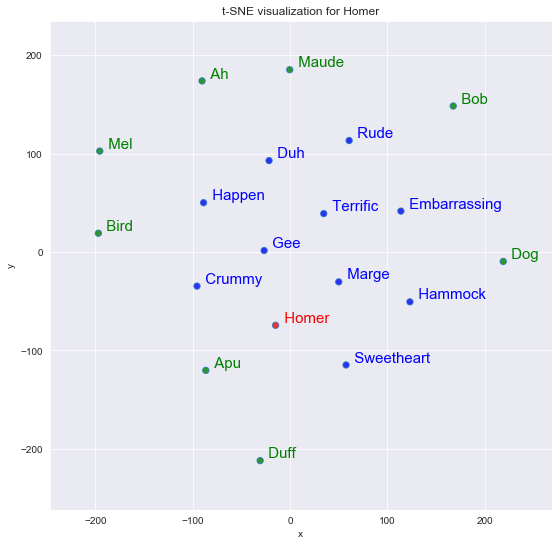

In [40]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

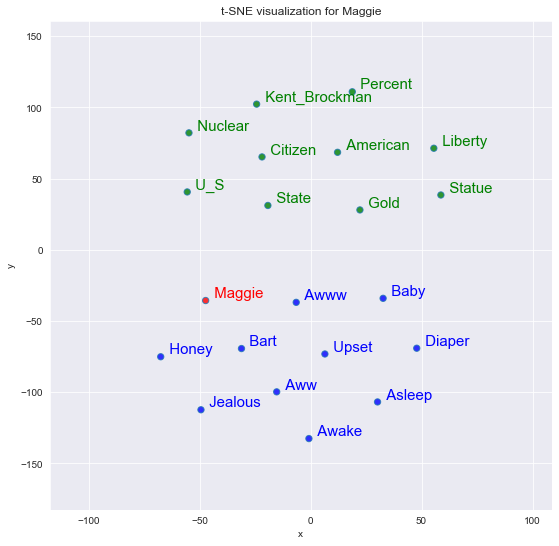

In [41]:
tsnescatterplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])])

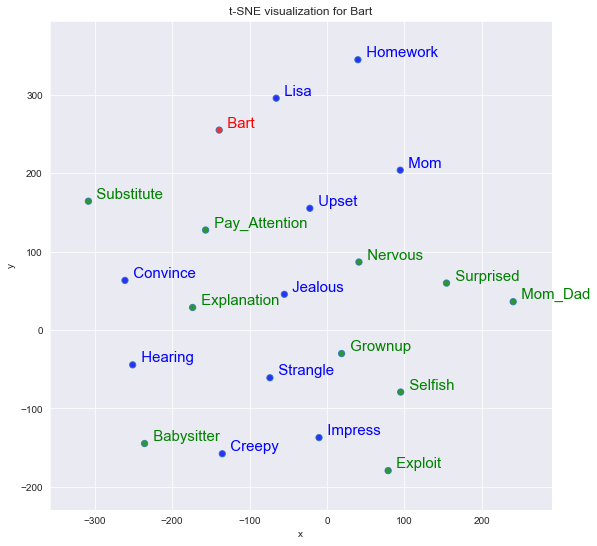

In [42]:
tsnescatterplot(w2v_model, "bart", [t[0] for t in w2v_model.wv.most_similar(positive=["bart"], topn=20)][10:])

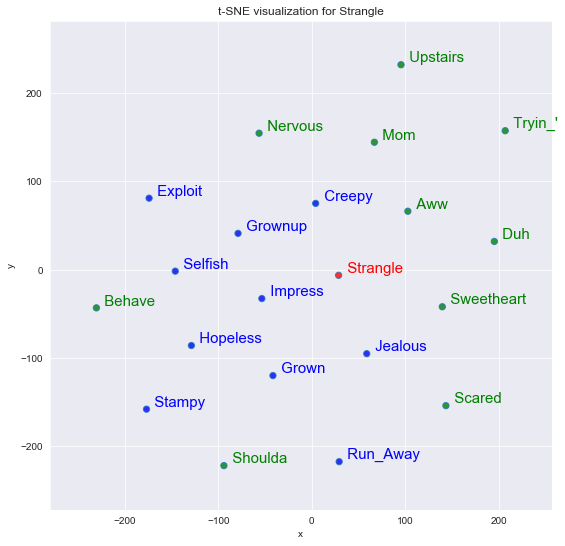

In [43]:
tsnescatterplot(w2v_model, "strangle", [t[0] for t in w2v_model.wv.most_similar(positive=["strangle"], topn=20)][10:])

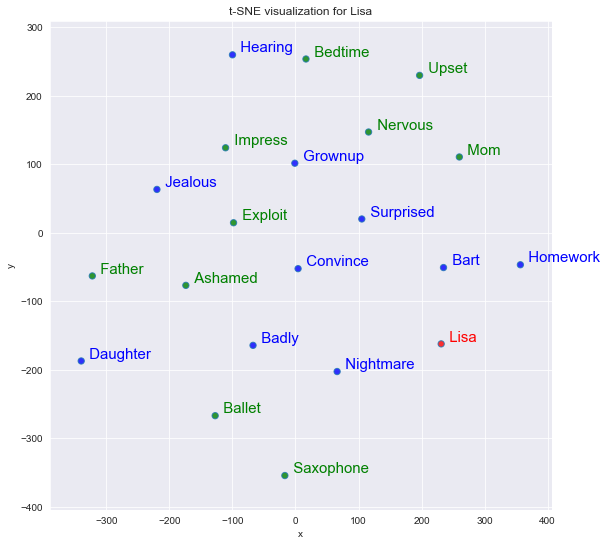

In [44]:
tsnescatterplot(w2v_model, "lisa", [t[0] for t in w2v_model.wv.most_similar(positive=["lisa"], topn=20)][10:])